# Evaluating Diffusion Models

In this notebook we'll look at some ways that we can evaluate diffusion models and other image generating models that go beyon a basic FID score.

## Loading a Diffusion Model for Testing

For this example notebook I'll use SD 2.1, for no particular reason. The same methods can be applied to any diffusion model, and any combination of scheduler and sampling settings.

In [ ]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

# Load the pipeline
model_id = "stabilityai/stable-diffusion-2-1"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)

# Add a different scheduler
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

# Move to GPU and use xformers if available
pipe.enable_xformers_memory_efficient_attention()
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading the tokenizer from the `special_tokens_map.json` and the `added_tokens.json` will be removed in `transformers 5`,  it is kept for forward compatibility, but it is recommended to update your `tokenizer_config.json` by uploading it again. You will see the new `added_tokens_decoder` attribute that will store the relevant information.


  0%|          | 0/25 [00:00<?, ?it/s]

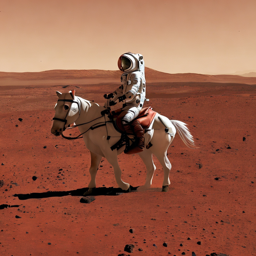

In [ ]:
# Generate an image to test that it works
prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt, num_inference_steps=25).images[0]
image.resize((256, 256)) # Small preview

## CLIP Score

CLIP let's us compute a "similarity score" between an image and a potential caption. While not perfect, this is a good measure for how well an image generating model is doing at matching the prompt. Important caveats:
- CLIP is great for objects, not so good at actions (verbs)
- CLIP can't really count, or keep track of placement
- Some models use a CLIP-based text encoder, which may make them look "better" at this metric relative to their actual performance.

Calculating a CLIP score for a text-image pair is relatively simple:

In [ ]:
from transformers import CLIPProcessor, CLIPModel

# Load the clip model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Preprocess the input text(s) and image(s)
inputs = clip_processor(text=[prompt], images=image, return_tensors="pt", padding=True)

# Inspect the outputs
outputs = clip_model(**inputs)
outputs.logits_per_image # A similarity score

tensor([[36.3408]], grad_fn=<TBackward0>)

A score of 35 indicates a pretty good match (depending on the CLIP model variant and lots of other factors). Compare this with what we get if the model produced that same image after being prompted to produce a flower:

In [ ]:
# Compare to an unrelated prompt
inputs = clip_processor(text=["A pretty flower"], images=image, return_tensors="pt", padding=True)
clip_model(**inputs).logits_per_image # Much lower similarity score

tensor([[16.4434]], grad_fn=<TBackward0>)

It is useful to plot CLIP score against some other metric. For example, increasing the CFG scale (guidance scale) increases the CLIP score, but as it gets higher the image quality may drop off as things start to look super saturated. FID score can be a rough proxy for this:

![image.png](attachment:image.png)

This figure from the SDXL paper that plots FID against CLIP score for several models, and notes that according to the FID score SDXL seems worse than the others, and only slightly better than them in terms of CLIP score. And yet in human evaluations SDXL is vastly preferred over SD1.5 or SD2.1.

## PickScore

![image.png](attachment:image.png)

The Pick-A-Pic project collected a large dataset if user preferences by having users select the best image in a group. This voting data was used to train a model, PickScore, which assigns a numeric score to an image taking the prompt into account. Their model does a pretty good job at predicting which image a person will prefer, and so it comes in very handy as a proxy for user preference. Here's how we could score a model:

In [ ]:
# import
from transformers import AutoProcessor, AutoModel
from PIL import Image
import torch

# load model
device = "cuda"
processor_name_or_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
model_pretrained_name_or_path = "yuvalkirstain/PickScore_v1"
processor = AutoProcessor.from_pretrained(processor_name_or_path)
model = AutoModel.from_pretrained(model_pretrained_name_or_path).eval().to(device)


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
# Score function adapted from their docs
def get_scores(prompt, images):

    # preprocess
    image_inputs = processor(
        images=images,
        padding=True,
        truncation=True,
        max_length=77,
        return_tensors="pt",
    ).to(device)

    text_inputs = processor(
        text=prompt,
        padding=True,
        truncation=True,
        max_length=77,
        return_tensors="pt",
    ).to(device)


    with torch.no_grad():
        # embed
        image_embs = model.get_image_features(**image_inputs)
        image_embs = image_embs / torch.norm(image_embs, dim=-1, keepdim=True)

        text_embs = model.get_text_features(**text_inputs)
        text_embs = text_embs / torch.norm(text_embs, dim=-1, keepdim=True)

        # score
        scores = model.logit_scale.exp() * (text_embs @ image_embs.T)[0]

    return scores.cpu().tolist()

In [ ]:
get_scores("a photo of an astronaut riding a horse on mars", image)

[22.669422149658203]

In [ ]:
get_scores("a photo of a pretty flower", image)

[16.105138778686523]

The Pick-a-pic dataset is also available. If we want a quick set of prompts to try out, we can load the validation prompts (not seen By the PickScore model) to test out:

In [ ]:
from datasets import load_dataset
pap = load_dataset("yuvalkirstain/pickapic_v1_no_images")
prompts = pap['validation_unique']['caption']
prompts[:3]

['Apocalyptic scenes of a meteor storm over a volcano.',
 'stained glass motif, whole body image of 20 year-old Riley Keough as an Elfin princess naturist in a magical mystic forest, HD 4k, sharp detail',
 'A giant robot with flashing lights and weapons']

Fair warning: these are user-submitted prompts and there's a lot of weird ones! Read at your own risk.

Now that we have a set of prompts and a model to evaluate generations, let's run some experiments!

## Measuring the effect of CFG_Scale on Score

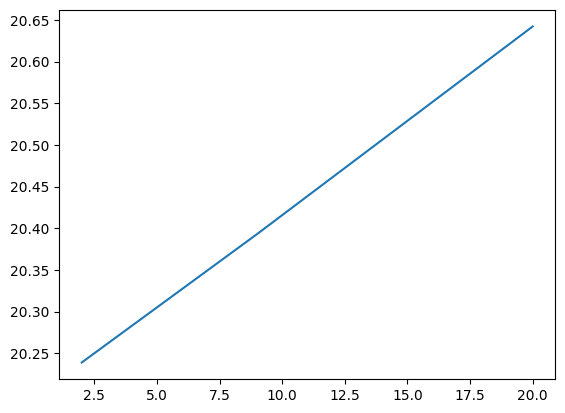

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

average_scores = []
cfg_scales = [2, 5, 9, 12, 30]
for cfg_scale in cfg_scales:
    scores = []
    for i, prompt in enumerate(prompts[:5]):
        print(f"Scale {cfg_scale}, prompt {i}")
        g = torch.Generator().manual_seed(i) # For reproducibility
        im = pipe(prompt, num_inference_steps=25,
                  generator=g, guidance_scale=cfg_scale).images[0]
        scores.append(get_scores(prompt, im)[0])
        clear_output(wait=True)
    average_scores.append(sum(scores)/len(scores))

plt.plot(cfg_scales, average_scores)

Something worth noting in the code above: we fix the seed across runs so that we can compare the effect of changing the CFG scale on the same set of prompts. If we didn't, there would be more variability in scores just due to different random starting points, so we'd need a larger set of prompts to get a good idea of the effect of CFG scale. I recommend doing this in any of your experiments. Some prompts are easier than others, so also make sure you test on the same set of prompts across models if you want the scores to be comparable.

## Using A Score Model for Re-Ranking

A trick that the origianl Dall-e paper used was to generate 256 images and use CLIP to pick the top few that best matched the prompt. This is an easy way to boost quality - generate lots and filter! If the preference model was perfect, generating 4 images and picking the best will beat generating a single image 80% of the time. Even if the score model isn't perfecct, generating lots and showing the user the top few is a good way to boost apparent quality (at the cost of compute time). Let's show this in action:

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

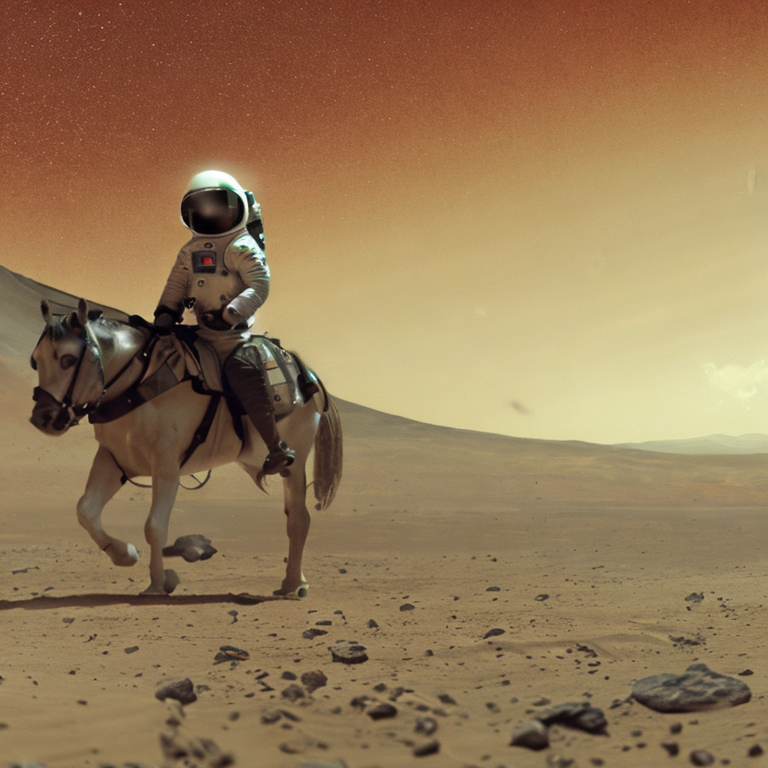

In [ ]:
def generate_good_image(prompt):
    images = []
    # Generate 4 images with two different guidance scales (for example):
    images += pipe(prompt, num_inference_steps=25, num_images_per_prompt=4).images
    images += pipe(prompt, num_inference_steps=25, num_images_per_prompt=4, guidance_scale=5).images
    # Score them and pick the best one
    scores = get_scores(prompt, images)
    best_image = images[scores.index(max(scores))]
    return best_image

generate_good_image("a photo of an astronaut riding a horse on mars")